# Bayes Nets
** A Julia package for Bayesian Networks **

A Bayesian Network (BN) represents a probability distribution over a set of variables, $P(x_1, x_2, \ldots, x_n)$. They leverage variable relations in order to efficiently decompose the joint distribution into smaller conditional probability distributions.

A BN is defined by a directed acyclic graph and a set of conditional probability distributions. Each node in the graph corresponds to a variable $x_i$ and is associated with a conditional probability distribution $P(x_i \mid \text{parents}(x_i))$.

## Installation

In [ ]:
Pkg.add("BayesNets");

Visualization of network structure is provided by the TikzGraphs package. Installation requirements (e.g., PGF/Tikz and pdf2svg) are provided [here](http://nbviewer.ipython.org/github/sisl/TikzGraphs.jl/blob/master/doc/TikzGraphs.ipynb).

## Use

In [1]:
srand(0) # seed the random number generator to 0, for demonstration purposes
using BayesNets

## Representation

Bayesian Networks are represented with the `BayesNet` type. This type contains the directed acyclic graph (a LightTables.DiGraph) and a list of BayesNetNodes (containing the variable's name, domain, and conditional probability distribution).

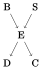

In [2]:
bn = BayesNet([:B, :S, :E, :D, :C]) # construct an edgeless network with five variables
                                    # note that this defaults to binary variables with 50/50 Bernoulli CPDs
add_edges!(bn, [(:B, :E), (:S, :E), (:E, :D), (:E, :C)]) # add edges, does not change CPDs

set_CPD!(bn, :B, CPDs.Bernoulli(0.1))
set_CPD!(bn, :S, CPDs.Bernoulli(0.5))
set_CPD!(bn, :E, CPDs.Bernoulli([:B, :S], rand_bernoulli_dict(2)))
set_CPD!(bn, :D, CPDs.Bernoulli([:E], rand_bernoulli_dict(1)))
set_CPD!(bn, :C, CPDs.Bernoulli([:E], rand_bernoulli_dict(1)))

bn

In [3]:
parents(bn, :E)

2-element Array{Symbol,1}:
 :B
 :S

In [4]:
domain(bn, :C)

BayesNets.CPDs.DiscreteDomain(Bool[false,true])

## Conditional Probability Distributions

Conditional Probablity Distributions, $P(x_i \mid \text{parents}(x_i))$, are defined in CPDs.jl. The current implementation provides `pdf(CPD, Assignment)` which returns an anonymous function over $x_i$'s distribution parameters.

$$P(C\mid A, B)$$

In [5]:
CPDs.Bernoulli( # conditional probability distribution
                [:A, :B], 
                Dict(
                     Assignment(:A=>true,  :B=>true)=>0.1,
                     Assignment(:A=>false, :B=>true)=>0.2,
                     Assignment(:A=>true,  :B=>false)=>0.3,
                     Assignment(:A=>false, :B=>false)=>0.4,
                ));

## Tables and Operations
Conditional probability distributions for discrete variables are often represented as conditional probability tables (CPTs). Their more general version are called factors. In BayesNets.jl these can be obtained using the `table` function, and are represented using DataFrames with one column per variable and one column `p` for the probability or factor value.

In [6]:
table(bn, :D)

,E,D,p
1,false,false,0.72
2,true,false,0.79
3,false,true,0.28
4,true,true,0.21


In [7]:
table(bn, :B)

,B,p
1,false,0.9
2,true,0.1


Tables/factors can be operated on via factor multiplication (`*`) and marginalization (`summout`)

In [8]:
bt = table(bn, :B)
st = table(bn, :S)
et = table(bn, :E)
tt = bt * et * st

,B,S,E,p
1,false,false,false,0.08100000000000003
2,false,false,true,0.369
3,true,false,false,0.004999999999999999
4,true,false,true,0.045000000000000005
5,false,true,false,0.3735
6,false,true,true,0.07650000000000001
7,true,true,false,0.04100000000000001
8,true,true,true,0.009


In [9]:
tt = sumout(tt, [:B, :S])

,E,p
1,false,0.5005000000000001
2,true,0.4995


## Computing Probability of Assignment

A Bayesian Network represents a joint probability distribution, $P(x_1, x_2, \ldots, x_n)$, and it is often necessary to evaluate that probability for a particular assignments.

Assignments are represented as dictionaries mapping variable names (Symbols) to variable values, typically `Dict{NodeName, Any}`

In [10]:
assignment = Assignment(
    :B=>0,
    :S=>1,
    :E=>0,
    :D=>1,
    :C=>1
)
prob(bn, assignment)

0.005229000000000001

## Sampling

Assignments can be sampled from a `BayesNet`.

In [11]:
rand(bn)

Dict{Any,Any} with 5 entries:
  :S => true
  :C => false
  :B => false
  :D => true
  :E => false

Multiple assignments can be sampled simultaneously and stored in a `DataFrame`

In [12]:
srand(0)
rand_table(bn, numSamples=5)

,B,C,D,E,S
1,false,false,false,true,false
2,true,false,false,true,true
3,false,false,true,true,false
4,false,false,false,false,false
5,true,false,true,false,true


In [13]:
srand(0)
t = rand_table(bn, numSamples=10, consistentWith=Assignment(:B=>true, :C=>false))

,B,C,D,E,S
1,true,false,false,true,true
2,true,false,true,false,true
3,true,false,true,true,true


The `estimate` function takes a set of samples and estimates the probability of each assignment based on its frequency of occurence

In [14]:
t = rand_table(bn, numSamples=100, consistentWith=Assignment(:B=>true, :C=>false))
estimate(t)

,B,C,D,E,S,p
1,true,false,false,false,true,0.5
2,true,false,false,true,false,0.25
3,true,false,false,true,true,0.25


## Structure Learning

BayesNets.jl supports several structure learning utilities (and will hopefully support structure learning soon!).

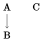

In [15]:
bn = BayesNet([:A, :B, :C])
add_edge!(bn, :A, :B)
set_CPD!(bn, :A, CPDs.Bernoulli(0.5))
set_CPD!(bn, :B, CPDs.Bernoulli(m->(m[:A] ? 0.5 : 0.45)))
set_CPD!(bn, :C, CPDs.Bernoulli(0.5))
bn

In [16]:
d = rand_table(bn, numSamples=5) # generate a dataset

,A,B,C
1,false,false,false
2,false,true,true
3,false,false,true
4,true,false,false
5,true,true,false


In [17]:
count(bn, d) # extract the number of times assignments occur for each variable

3-element Array{DataFrames.DataFrame,1}:
 2x2 DataFrames.DataFrame
| Row | A     | count |
|-----|-------|-------|
| 1   | false | 3     |
| 2   | true  | 2     |                                                                                                
 4x3 DataFrames.DataFrame
| Row | A     | B     | count |
|-----|-------|-------|-------|
| 1   | false | false | 2     |
| 2   | false | true  | 1     |
| 3   | true  | false | 1     |
| 4   | true  | true  | 1     |
 2x2 DataFrames.DataFrame
| Row | C     | count |
|-----|-------|-------|
| 1   | false | 3     |
| 2   | true  | 2     |

In [18]:
log_bayes_score(bn, d) # compute the log Bayesian score for the Bayesian Network on a dataset

-12.465355243460259

In [19]:
bn = BayesNet([:A, :B, :C])

In [20]:
log_bayes_score(bn, d) # poor structures will produce lower Bayesian scores

-12.283033686666304